<a href="https://colab.research.google.com/github/LeeJaeEun0/st1223/blob/main/221221_ch04_ML_07_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 부스팅 모델
* 순차적으로 트리를 만들어 이전트리보다 더 나은 트리를 만들어내는 알고리즘
  * 랜덤트리 포레스트
* XG부스트(XGBoost), 라이트GBM

* 부스팅
  * 랜덤 포레스트 = 트리를 만들어 랜덤으로 사용 =꼭 좋은 결과만 나오지 않음
  * 부스터는 순차적으로 만들어 

* XGBoost
  * 성능이 검증된 부스팅 모델
  * 구글 - 참고할만한 자료가 많음
  * 이미지, 자연어가 아닌 경우 거의 모든 상황에서 사용 가능함

* 장점
  * 속도가 상당히 빠르고 예측력이 좋음
  * 변수 종류가 많고 데이터가 클수록 상대적으로 뛰어난 성능을 보여줌

* 단점
  * 복잡한 모델인만큼 해석이 어려움
    * 선형회귀 같은 설명이 가능한 방법도 같이 사용하면 좋다.
  * 더 나은 성능을 위한 하이퍼파라미터 튜닝이 어려움
    * 이미 좋은 결과가 나와서 더 개선하기 어려움

## Speed Dating Experiment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment
# https://raw.githubusercontent.com/bigdata-young/ai_26th/main/data/dating.csv
df = pd.read_csv("https://raw.githubusercontent.com/bigdata-young/ai_26th/main/data/dating.csv")
df

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.00,27.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,35.00,20.00,...,7.00,6.00,5.00,0.14,3.00,2.00,7.00,6.00,0.00,0
1,0,female,21.00,22.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,60.00,0.00,...,8.00,5.00,6.00,0.54,3.00,2.00,7.00,5.00,1.00,0
2,1,female,21.00,22.00,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.00,4.00,19.00,18.00,...,8.00,5.00,7.00,0.16,3.00,2.00,7.00,NaN,1.00,1
3,0,female,21.00,23.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,30.00,5.00,...,7.00,6.00,8.00,0.61,3.00,2.00,7.00,6.00,0.00,1
4,0,female,21.00,24.00,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.00,4.00,30.00,10.00,...,7.00,6.00,6.00,0.21,3.00,2.00,6.00,6.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,male,25.00,26.00,European/Caucasian-American,Latino/HispanicAmerican,1.00,1.00,10.00,10.00,...,5.00,NaN,NaN,0.64,10.00,NaN,2.00,5.00,0.00,0
8374,1,male,25.00,24.00,European/Caucasian-American,Other,1.00,1.00,50.00,20.00,...,4.00,4.00,NaN,0.71,10.00,NaN,4.00,4.00,0.00,0
8375,1,male,25.00,29.00,European/Caucasian-American,Latino/HispanicAmerican,1.00,1.00,40.00,10.00,...,8.00,8.00,NaN,-0.46,10.00,NaN,6.00,5.00,0.00,0
8376,1,male,25.00,22.00,European/Caucasian-American,Asian/PacificIslander/Asian-American,1.00,1.00,10.00,25.00,...,4.00,NaN,5.00,0.62,10.00,NaN,5.00,5.00,0.00,0


# 변수 목록
## 목표값, 종속변수, 라벨, y
* match
## 관측값, 독립변수, 피처, X
* has_null
    - 변수 중 Null값이 있는지 여부. 단, 이 데이터는 기존 데이터에서 일부 변수들이 생략된 축소판이기 때문에, 여기서 보이는 Null값 여부와 다소 차이가 있을 수 있음.
    - 전반적으로 무응답 항목이 있는지에 대한 정보이므로 그대로 사용
* age / age_o : age는 본인 나이이며 age_o는 상대방 나이.
* race / race_o : 마찬가지로 본인과 상대의 인종 정보.
* importance_same_race / importance_same_religion
    * 인종과 종교를 중요시 여기는지에 대한 응답
* attractive(매력적인), sincere(성실한), intelligence(지적), funny(재미난), ambitious(야심찬), shared_ interests(공통관심사) : 이 항목들은 4가지 관점에서 평가되어 총 변수가 24(6 × 4)개
    * pref_o_xxx( 예 : pref_o_attractive) : 상대방이 xxx 항목을 얼마나 중요하게 생각하는가에 대한 응답
    * xxx_o(예: attractive_o) : 상대방이 본인에 대한 xxx 항목을 평가한 항목
    * xxx_important(예 : attractive_important) : xxx 항목에 대해 본인이 얼마나 중요하게 생각하는가에 대한 응답
    * xxx_partner(예 : attractive_partner) : 본인이 상대방에 대한 xxx 항목을 평가한 항목
* interests_correlate : 관심사(취미 등) 연관도
* expected_happy_with_sd_people : 스피드 데이팅을 통해 만난 사람과 함께할 때 얼마나 좋을
지에 대한 기대치
* expected_num_interested_in_me : 얼마나 많은 사람이 나에게 관심을 보일지에 대한 기대치
* like : 파트너가 마음에 들었는지 여부
* guess_prob_liked : 파트너가 나를 마음에 들어했을지에 대한 예상
* met: 파트너를 스피드 데이팅 이벤트 이전에 만난 적이 있는지 여부

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

In [ ]:
pd.options.display.float_format = "{:.2f}".format
df.describe()

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
count,8378.00,8283.00,8274.00,8299.00,8299.00,8289.00,8289.00,8289.00,8280.00,8271.00,...,8028.00,7666.00,7311.00,8220.00,8277.00,1800.00,8138.00,8069.00,8003.00,8378.00
mean,0.87,26.36,26.36,3.78,3.65,22.50,17.40,20.27,17.46,10.69,...,6.40,6.78,5.47,0.20,5.53,5.57,6.13,5.21,0.05,0.16
std,0.33,3.57,3.56,2.85,2.81,12.57,7.04,6.78,6.09,6.13,...,1.95,1.79,2.16,0.30,1.73,4.76,1.84,2.13,0.28,0.37
min,0.00,18.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.83,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,24.00,24.00,1.00,1.00,15.00,15.00,17.39,15.00,5.00,...,5.00,6.00,4.00,-0.02,5.00,2.00,5.00,4.00,0.00,0.00
50%,1.00,26.00,26.00,3.00,3.00,20.00,18.37,20.00,18.00,10.00,...,7.00,7.00,6.00,0.21,6.00,4.00,6.00,5.00,0.00,0.00
75%,1.00,28.00,28.00,6.00,6.00,25.00,20.00,23.81,20.00,15.00,...,8.00,8.00,7.00,0.43,7.00,8.00,7.00,7.00,0.00,0.00
max,1.00,55.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,...,10.00,10.00,10.00,0.91,10.00,20.00,10.00,10.00,8.00,1.00


In [ ]:
df.describe(include='O') # 대문자O # race는 인종, race_o는 상대방인종

,gender,race,race_o
count,8378,8315,8305
unique,2,5,5
top,male,European/Caucasian-American,European/Caucasian-American
freq,4194,4727,4722


# 전처리

## 결측치

In [ ]:
df.isna().mean() # 결측치 확인하기 # 오름차순 , 행방향은 데이터가 작 -> 큰

has_null                        0.00
gender                          0.00
age                             0.01
age_o                           0.01
race                            0.01
race_o                          0.01
importance_same_race            0.01
importance_same_religion        0.01
pref_o_attractive               0.01
pref_o_sincere                  0.01
pref_o_intelligence             0.01
pref_o_funny                    0.01
pref_o_ambitious                0.01
pref_o_shared_interests         0.02
attractive_o                    0.03
sincere_o                       0.03
intelligence_o                  0.04
funny_o                         0.04
ambitous_o                      0.09
shared_interests_o              0.13
attractive_important            0.01
sincere_important               0.01
intellicence_important          0.01
funny_important                 0.01
ambtition_important             0.01
shared_interests_important      0.01
attractive_partner              0.02
s

In [ ]:
df.isna().mean().sort_values(ascending=False) # 내림차순 (행방향=데이터 작아지는 방향)

expected_num_interested_in_me   0.79
shared_interests_o              0.13
shared_interests_partner        0.13
ambitous_o                      0.09
ambition_partner                0.08
met                             0.04
funny_o                         0.04
funny_partner                   0.04
guess_prob_liked                0.04
intelligence_o                  0.04
intelligence_partner            0.04
sincere_o                       0.03
sincere_partner                 0.03
like                            0.03
attractive_o                    0.03
attractive_partner              0.02
interests_correlate             0.02
pref_o_shared_interests         0.02
shared_interests_important      0.01
pref_o_ambitious                0.01
age_o                           0.01
expected_happy_with_sd_people   0.01
ambtition_important             0.01
pref_o_funny                    0.01
age                             0.01
pref_o_sincere                  0.01
pref_o_attractive               0.01
f

In [ ]:
# na를 다 drop하는 게 아니라, 특정한 열 결측치가 있을 경우만 행을 삭제
# subset = [결측치가 있다면 행을 삭제할 열들 이름]
# 일부 변수에서 결측치 제거
df = df.dropna(
    subset=[
        'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
        'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
        'attractive_important', 'sincere_important', 'intellicence_important',
        'funny_important', 'ambtition_important', 'shared_interests_important']
)

In [ ]:
df.isna().mean().sort_values(ascending=False)

expected_num_interested_in_me   0.79
shared_interests_o              0.13
shared_interests_partner        0.13
ambitous_o                      0.08
ambition_partner                0.08
met                             0.04
funny_o                         0.04
funny_partner                   0.04
guess_prob_liked                0.04
intelligence_o                  0.03
intelligence_partner            0.03
sincere_o                       0.03
sincere_partner                 0.03
like                            0.03
attractive_partner              0.02
attractive_o                    0.02
age_o                           0.00
age                             0.00
expected_happy_with_sd_people   0.00
funny_important                 0.00
interests_correlate             0.00
shared_interests_important      0.00
ambtition_important             0.00
has_null                        0.00
intellicence_important          0.00
sincere_important               0.00
attractive_important            0.00
g

In [ ]:
# 결측치를 모두 -99로 채우기
df.fillna(-99, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
# 결측치 처리 완료
df.isna().mean().sort_values(ascending=False)

has_null                        0.00
funny_partner                   0.00
intellicence_important          0.00
funny_important                 0.00
ambtition_important             0.00
shared_interests_important      0.00
attractive_partner              0.00
sincere_partner                 0.00
intelligence_partner            0.00
ambition_partner                0.00
attractive_important            0.00
shared_interests_partner        0.00
interests_correlate             0.00
expected_happy_with_sd_people   0.00
expected_num_interested_in_me   0.00
like                            0.00
guess_prob_liked                0.00
met                             0.00
sincere_important               0.00
shared_interests_o              0.00
gender                          0.00
pref_o_sincere                  0.00
age                             0.00
age_o                           0.00
race                            0.00
race_o                          0.00
importance_same_race            0.00
i

In [ ]:
# 결측치만 채운 상태에서 XGBoost로 모델링 결과
# -> 피처 엔지니어링을 통해서 변수를 변형/추가 했을 경우에 결과
df['match'].mean() # 16.4% 성사 확률 (1)
1 - df['match'].mean() # 83.5% 서로 안맞을 확률 (0)
# -> 안맞는다고만 해도 83%

0.8351783517835178

## 피처엔지니어링 없이 모델링

In [ ]:
df2 = df.copy()

In [ ]:
df2.describe(include='O').columns

Index(['gender', 'race', 'race_o'], dtype='object')

In [ ]:
df2 = pd.get_dummies(df2, columns=df2.describe(include='O').columns)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 0 to 8377
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   has_null                                     8130 non-null   int64  
 1   age                                          8130 non-null   float64
 2   age_o                                        8130 non-null   float64
 3   importance_same_race                         8130 non-null   float64
 4   importance_same_religion                     8130 non-null   float64
 5   pref_o_attractive                            8130 non-null   float64
 6   pref_o_sincere                               8130 non-null   float64
 7   pref_o_intelligence                          8130 non-null   float64
 8   pref_o_funny                                 8130 non-null   float64
 9   pref_o_ambitious                             8130 non-null   float64
 10  

In [ ]:
X = df2.drop('match', axis=1)
y = df2['match']

In [ ]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(
    X, y, test_size=0.2, random_state=230
)

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier(random_state=23)

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(random_state=23)

In [ ]:
pred = model.predict(X_test)
pred

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred)

0.861469864698647

[[5223  240]
 [ 661  380]]


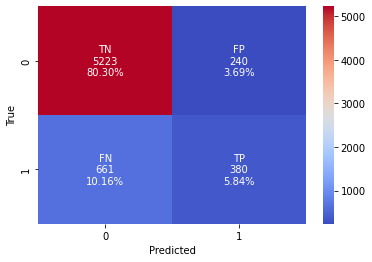

In [ ]:
from sklearn.metrics import confusion_matrix

# 오른쪽 위 : 1종 오류 - 실제 틀린데 (0) 맞다고 예측 (1) - 68
# 왼쪽 아래 : 2종 오류 - 실제 맞는데 (1) 틀리다고 예측 (0) - 147
print(confusion_matrix(y_test, pred))
cf_matrix = confusion_matrix(y_test,pred)
cf_matrix
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
# TP(양성을 양성으로 판단)
# FN(양성을 음성으로 판단) -> 2종 오류 (맞는데 틀리다고)
# FP(음성을 양성으로 판단) -> 1종 오류 (틀린데 맞다고)
# TN(음성을 음성으로 판단) 

## 피처 엔지니어링
* 피처(Feature, 특징): 독립변수
* 엔지니어링 : 가공을 해서 더 유의미하게 만들겠다
---
* Titanic -> Name => Title
* 단위 -> 통일

### age_gap

In [ ]:
# age : 본인의 나이, age_o : 상대방의 나이
df.age.isnull().mean()

0.0

In [ ]:
df.age_o.isnull().mean()

0.0

In [ ]:
# -99인 결측치의 비율
(df.age == -99).mean()

0.002706027060270603

In [ ]:
# -99인 결측치의 비율
(df.age_o == -99).mean()

0.002706027060270603

In [ ]:
# 1. 내 나이가 결측치일 경우 -> 결측치
# 2. 상대방의 나이가 결측치일 경우 -> 결측치
# 3. 상대방과 내 나이가 모두 있을 경우 (차이를 구할 수 있음)
# 3-1. (내가 남성) : 상대방과 나이 차이 -> 내 나이에서 상대방 나이를 빼고
# 3-2. (... 여성) : 상대방과 나이 차이 -> 상대방 나이에서 내 나이를 빼는 방식
# df.apply(..., axis=1) -> 특정 행의 전체 열
# df.age = 본인 나이, df.age_o = 상대방 나이
def age_gap(row):
    # 1. 내 나이가 결측치(-99)일 경우
    if row.age == -99: return -99 # return => 함수가 뒤를 더 이상 처리 X
    # 2. 상대방 나이가 ...
    if row.age_o == -99: return -99
    # 3-1. 남성일 경우 -> 내 나이 - 상대방 나이
    if row.gender == 'male': return row.age - row.age_o
    # 3-2. 여성일 경우 -> 상대방 나이 - 내 나이
    if row.gender == 'female': return row.age_o - row.age
    # 나머지 값은 X

In [ ]:
df.gender.unique()

array(['female', 'male'], dtype=object)

In [ ]:
df['age_gap'] = df.apply(age_gap, axis=1) # 행을 기준으로 모든 열을 사용해주려면...

<ipython-input-191-8f81cf550e64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_gap'] = df.apply(age_gap, axis=1) # 행을 기준으로 모든 열을 사용해주려면...


In [ ]:
# 나이차이 +  성별간의 차이
df.age_gap.head()

0   6.00
1   1.00
2   1.00
3   2.00
4   3.00
Name: age_gap, dtype: float64

In [ ]:
# abs : 절대값 -> 성별의 영향 없이 진짜 나이 차이만 보겠다
def age_gap_abs(row):
    # 1. 내 나이가 결측치(-99)일 경우
    if row.age == -99: return -99 # return => 함수가 뒤를 더 이상 처리 X
    # 2. 상대방 나이가 ...
    if row.age_o == -99: return -99
    # 3. 둘 사이의 차이를 abs() -> 절대값으로 나타내기
    return abs(row.age - row.age_o)

In [ ]:
df['age_gap_abs'] = df.apply(age_gap_abs, axis=1) # 행을 기준으로 모든 열을 사용해주려면...

<ipython-input-194-078ffd45d7ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_gap_abs'] = df.apply(age_gap_abs, axis=1) # 행을 기준으로 모든 열을 사용해주려면...


In [ ]:
df['age_gap'].unique()

array([  6.,   1.,   2.,   3.,   4.,   9.,   7.,  -2.,  -1.,   0.,  -3.,
         5.,   8.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -12., -13., -10.,
        17.,  10.,  16.,  13.,  12.,  11.,  14., -14., -11.,  18.,  15.,
        19.,  20., -16., -15., -22., -28., -32., -99.])

In [ ]:
df['age_gap_abs'].unique() # 마이너스 값이 없음

array([  6.,   1.,   2.,   3.,   4.,   9.,   7.,   0.,   5.,   8.,  12.,
        13.,  10.,  17.,  16.,  11.,  14.,  18.,  15.,  19.,  20.,  22.,
        28.,  32., -99.])

### race

In [ ]:
# 내 인종
df.race.value_counts()

European/Caucasian-American             4629
Asian/PacificIslander/Asian-American    1946
Latino/HispanicAmerican                  631
Other                                    513
Black/AfricanAmerican                    411
Name: race, dtype: int64

In [ ]:
# 상대방 인종
df.race_o.value_counts()

European/Caucasian-American             4629
Asian/PacificIslander/Asian-American    1946
Latino/HispanicAmerican                  631
Other                                    513
Black/AfricanAmerican                    411
Name: race_o, dtype: int64

In [ ]:
# 1. 인종이 일치하나?
# 2. 일치 여부에 따라서 중요도를 곱해서 점수화
# df.race : 내 인종
# df.race_o : 상대방 인종
# df.apply(..., axis=1) 특정 행의 모든 열의 데이터를 조회
def same_race(row):
    # 결측치 (-99)
    if row.race == -99 or row.race_o == -99: return -99
    if row.race == row.race_o: return 1
    return -1
    # 삼항연산자
    # {조건을 만족시켰을 때의 결과값} if {조건} else {만족X 결과값}
    # return 1 if row.race == row.race_o else -1

    # 8378 -  내꺼에 200개 정도 더 있음??????????/

In [ ]:
df['same_race'] = df.apply(same_race, axis=1)

<ipython-input-200-14bcb61b2ee3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_race'] = df.apply(same_race, axis=1)


In [ ]:
df['same_race'].value_counts()

-1    4844
 1    3286
Name: same_race, dtype: int64

In [ ]:
df.importance_same_race.value_counts()

1.00     2749
3.00      964
2.00      938
5.00      644
8.00      631
7.00      536
6.00      516
4.00      494
9.00      404
10.00     246
0.00        8
Name: importance_same_race, dtype: int64

In [ ]:
df.importance_same_race == 10

0       False
1       False
2       False
3       False
4       False
        ...  
8372    False
8373    False
8374    False
8376    False
8377    False
Name: importance_same_race, Length: 8130, dtype: bool

In [ ]:
df[df.importance_same_race == 10]['match'].mean()

0.12601626016260162

In [ ]:
def same_race_point(row):
    if row.same_race == -99: return -99
    return row.same_race * row.importance_same_race

In [ ]:
df['same_race_point'] = df.apply(same_race_point, axis=1)

<ipython-input-206-9027ec13be1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_race_point'] = df.apply(same_race_point, axis=1)


In [ ]:
df.same_race_point.value_counts()

-1.00     1765
1.00       984
-3.00      611
-2.00      575
2.00       363
-5.00      354
3.00       353
8.00       321
-6.00      316
-7.00      312
-8.00      310
5.00       290
-4.00      272
7.00       224
4.00       222
-9.00      211
6.00       200
9.00       193
10.00      130
-10.00     116
0.00         8
Name: same_race_point, dtype: int64

In [ ]:
df[df.same_race_point == 10]['match'].mean()

0.17692307692307693

In [ ]:
df[df.same_race_point == -10]['match'].mean() # 차이가 있음을 알 수 있음

0.06896551724137931

In [ ]:
df[['race', 'race_o', 'same_race', 'importance_same_race', 'same_race_point']]

,race,race_o,same_race,importance_same_race,same_race_point
0,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
1,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
2,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,1,2.00,2.00
3,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
4,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,-1,2.00,-2.00
...,...,...,...,...,...
8372,European/Caucasian-American,European/Caucasian-American,1,1.00,1.00
8373,European/Caucasian-American,Latino/HispanicAmerican,-1,1.00,-1.00
8374,European/Caucasian-American,Other,-1,1.00,-1.00
8376,European/Caucasian-American,Asian/PacificIslander/Asian-American,-1,1.00,-1.00


### importance & score 
* 어느 여역을 중요하게 여기는가? 그것에 대한 점수3 

In [ ]:
df.columns

Index(['has_null', 'gender', 'age', 'age_o', 'race', 'race_o',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o',
       'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'interests_correlate',
       'expected_happy_with_sd_people', 'expected_num_interested_in_me',
       'like', 'guess_prob_liked', 'met', 'match', 'age_gap', 'age_gap_abs',
       'same_race', 'same_race_point'],
      dtype='object')

In [ ]:
# A : 나, B : 상대방
df.columns[8:14] # 상대방이 원하는 선호도(8~13) # 이상형같이 원하는 모습
# B가 특정한 영역에 대해서 얼마나 선호하는지

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests'],
      dtype='object')

In [ ]:
df.columns[14:20] # 본인에 대한 상대방의 평가
# 나(A)에 대한 상대방(B)의 평가
# => 나에 대한 상대방의 특정 영역에 대한 점수

Index(['attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o'],
      dtype='object')

In [ ]:
df.columns[20:26] # 나(본인)의 선호도, 중요도 (20~25) # 이상형같이 원하는 모습
# A(나)가 특정한 영역에 대해서 얼마나 중요한지

Index(['attractive_important', 'sincere_important', 'intellicence_important',
       'funny_important', 'ambtition_important', 'shared_interests_important'],
      dtype='object')

In [ ]:
df.columns[26:32] # 상대방에 대한 본인의 평가
# 나(A)에 대한 상대방(B)의 평가

Index(['attractive_partner', 'sincere_partner', 'intelligence_partner',
       'funny_partner', 'ambition_partner', 'shared_interests_partner'],
      dtype='object')

In [ ]:
print(f"상대방의 선호도 : {df.columns[8:14].tolist()}")
print(f"본인에 대한 상대방의 평가 : {df.columns[14:20].tolist()}")
print(f"본인의 선호도 : {df.columns[20:26].tolist()}")
print(f"상대방에 대한 본인의 평가 : {df.columns[26:32].tolist()}")

상대방의 선호도 : ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']
본인에 대한 상대방의 평가 : ['attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o']
본인의 선호도 : ['attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important']
상대방에 대한 본인의 평가 : ['attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner']


In [ ]:
partner_imp = df.columns[8:14] # 상대방이 얼마나 중요하게 여기는지
partner_rate_me = df.columns[14:20] # 나에 대한 상대방의 평가
my_imp = df.columns[20:26] # 내가 얼마나 중요하게 여기는지
my_rate_partner = df.columns[26:32] # 상대방에 대한 나의 평가

In [ ]:
# imp & rate => 평가(score)
new_label_partner = ['attractive_p',
                     'sincere_p',
                     'intelligence_p',
                     'funny_p',
                     'ambitous_p',
                     'shared_interests_p']
# partner가 나에 대해 중요도 * 평가 -> 최종 평가
new_label_me = ['attractive_m',
                'sincere_m',
                'intelligence_m',
                'funny_m',
                'ambitous_m',
                'shared_interests_m']
# 내가 상대방에 대해 중요도 * 평가 -> 최종 평가

In [ ]:
# 얼마나 중요한지, 평가 대상에 대한 점수
# row -> importance: 중요도 열이름, score: 평가 열 이름
def rating(row, importance, score):
  # 둘 중에 하나라도 결측치면 -> -99로 만들고
  if (row[importance] == -99) or (row[score] == -99): return -99
  # 둘 다 결측치가 아니면 중요도 * 평가 => return
  return row[importance] * row[score]


In [ ]:
# 평가 점수 열 이름, 중요도 열 이름 -> 새로운 라벨 열 이름
# 파트너 -> 나
for i, j, k in zip(new_label_partner, partner_imp, partner_rate_me):
  print(f"{i} & {j} & {k}")

attractive_p & pref_o_attractive & attractive_o
sincere_p & pref_o_sincere & sincere_o
intelligence_p & pref_o_intelligence & intelligence_o
funny_p & pref_o_funny & funny_o
ambitous_p & pref_o_ambitious & ambitous_o
shared_interests_p & pref_o_shared_interests & shared_interests_o


In [ ]:
# 파트너가 나에게 느끼는 점수
for i, j, k in zip(new_label_partner, partner_imp, partner_rate_me):
    # print(f"{i} & {j} & {k}")
    # i : 새롭게 만들, 파트너가 내게 느끼는 중요도x점수
    # j : 파트너가 중요하게 여기는 정도 (importance)
    # k ; 나에 대한 파트너의 평가 (score)
    # apply 내부는 -> 변수를 1개만 제공 (row)
    df[i] = df.apply(lambda row: rating(row, j, k) , axis=1)

<ipython-input-221-909abe6155bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row: rating(row, j, k) , axis=1)


In [ ]:
df.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,age_gap,age_gap_abs,same_race,same_race_point,attractive_p,sincere_p,intelligence_p,funny_p,ambitous_p,shared_interests_p
0,0,female,21.00,27.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,35.00,20.00,...,6.00,6.00,-1,-2.00,210.00,160.00,160.00,160.00,0.00,30.00
1,0,female,21.00,22.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,60.00,0.00,...,1.00,1.00,-1,-2.00,420.00,0.00,0.00,280.00,0.00,0.00
2,1,female,21.00,22.00,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.00,4.00,19.00,18.00,...,1.00,1.00,1,2.00,190.00,180.00,190.00,180.00,140.00,120.00
3,0,female,21.00,23.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,30.00,5.00,...,2.00,2.00,-1,-2.00,210.00,40.00,135.00,320.00,45.00,40.00
4,0,female,21.00,24.00,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.00,4.00,30.00,10.00,...,3.00,3.00,-1,-2.00,240.00,70.00,180.00,60.00,90.00,140.00


In [ ]:
# 내가 상대방에게 느끼는 점수
for i, j, k in zip(new_label_me, my_imp, my_rate_partner):
    # print(f"{i} & {j} & {k}")
    # i : 새롭게 만들, 중요도x점수
    # j : 중요하게 여기는 정도 (importance)
    # k ; 평가 (score)
    # apply 내부는 -> 변수를 1개만 제공 (row)
    df[i] = df.apply(lambda row: rating(row, j, k) , axis=1)

<ipython-input-223-eca645f9409d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row: rating(row, j, k) , axis=1)


In [ ]:
df.columns

Index(['has_null', 'gender', 'age', 'age_o', 'race', 'race_o',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o',
       'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'interests_correlate',
       'expected_happy_with_sd_people', 'expected_num_interested_in_me',
       'like', 'guess_prob_liked', 'met', 'match', 'age_gap', 'age_gap_abs',
       'same_race', 'same_race_point', 'attractive_p', 'sincere_p',
       'intelligence_p', 'funny_p', 'ambitous_p', 'shared_interests_p',
       'attractiv

## 범주형 변수

In [ ]:
df = pd.get_dummies(df, columns=df.describe(include='O').columns, drop_first=True)
df

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,...,shared_interests_m,gender_male,race_Black/AfricanAmerican,race_European/Caucasian-American,race_Latino/HispanicAmerican,race_Other,race_o_Black/AfricanAmerican,race_o_European/Caucasian-American,race_o_Latino/HispanicAmerican,race_o_Other
0,0,21.00,27.00,2.00,4.00,35.00,20.00,20.00,20.00,0.00,...,75.00,0,0,0,0,0,0,1,0,0
1,0,21.00,22.00,2.00,4.00,60.00,0.00,0.00,40.00,0.00,...,90.00,0,0,0,0,0,0,1,0,0
2,1,21.00,22.00,2.00,4.00,19.00,18.00,19.00,18.00,14.00,...,105.00,0,0,0,0,0,0,0,0,0
3,0,21.00,23.00,2.00,4.00,30.00,5.00,15.00,40.00,5.00,...,120.00,0,0,0,0,0,0,1,0,0
4,0,21.00,24.00,2.00,4.00,30.00,10.00,20.00,10.00,10.00,...,90.00,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,1,25.00,24.00,1.00,1.00,10.00,15.00,30.00,20.00,15.00,...,-99.00,1,0,1,0,0,0,1,0,0
8373,1,25.00,26.00,1.00,1.00,10.00,10.00,30.00,20.00,10.00,...,-99.00,1,0,1,0,0,0,0,1,0
8374,1,25.00,24.00,1.00,1.00,50.00,20.00,10.00,5.00,10.00,...,-99.00,1,0,1,0,0,0,0,0,1
8376,1,25.00,22.00,1.00,1.00,10.00,25.00,25.00,10.00,10.00,...,0.00,1,0,1,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 0 to 8377
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   has_null                            8130 non-null   int64  
 1   age                                 8130 non-null   float64
 2   age_o                               8130 non-null   float64
 3   importance_same_race                8130 non-null   float64
 4   importance_same_religion            8130 non-null   float64
 5   pref_o_attractive                   8130 non-null   float64
 6   pref_o_sincere                      8130 non-null   float64
 7   pref_o_intelligence                 8130 non-null   float64
 8   pref_o_funny                        8130 non-null   float64
 9   pref_o_ambitious                    8130 non-null   float64
 10  pref_o_shared_interests             8130 non-null   float64
 11  attractive_o                        8130 no

# 모델링

In [ ]:
from sklearn.model_selection import train_test_split
# 나중에는 하이퍼파라미터, XFold 등 여러개의 알고리즘을 같이 테스트 해야한다.

X=df.drop('match',axis=1)
y=df['match']
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=230
)

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRFClassifier(random_state=230)

In [ ]:
model.fit(X_train, y_train)

XGBRFClassifier(random_state=230)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
print(accuracy_score(y_train, train_pred)) # 학습율
print(accuracy_score(y_test, test_pred))

0.8537822878228782
0.8290282902829028


In [ ]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    random_state=23,
    n_jobs=-1)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(accuracy_score(y_train, train_pred)) # 학습율
print(accuracy_score(y_test, test_pred)) # 오버피팅이지만 올라감

0.9998462484624846
0.8560885608856088


[[1265   62]
 [ 172  127]]


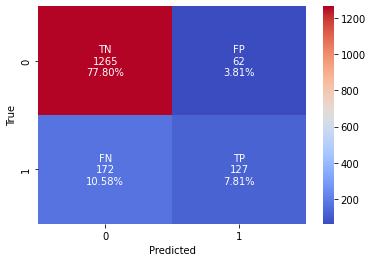

In [ ]:
from sklearn.metrics import confusion_matrix

# 오른쪽 위 : 1종 오류 - 실제 틀린데 (0) 맞다고 예측 (1) - 68
# 왼쪽 아래 : 2종 오류 - 실제 맞는데 (1) 틀리다고 예측 (0) - 147
print(confusion_matrix(y_test, test_pred))
cf_matrix = confusion_matrix(y_test, test_pred)
cf_matrix
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
# TP(양성을 양성으로 판단)
# FN(양성을 음성으로 판단) -> 2종 오류 (맞는데 틀리다고)
# FP(음성을 양성으로 판단) -> 1종 오류 (틀린데 맞다고)
# TN(음성을 음성으로 판단) 


|이ㅣ건|제목||
|-|-|-|
|||정밀도|
||1265|62|
|재현율|172<br>오른쪽보다 커선 안좋아 ㅜ|127|

## Classficatioin Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1327
           1       0.67      0.42      0.52       299

    accuracy                           0.86      1626
   macro avg       0.78      0.69      0.72      1626
weighted avg       0.84      0.86      0.84      1626



* 0: match 성사가 안된 경우
* **1: match 성사된 경우** (분석대상이 되는쪽, 예측대상* 0 : match 성사가 안 된 경우
* **1 : match 성사된 경우** (분석대상이 되는쪽, 예측대상)
* `precision` : 정밀도
* `recall` : 재현율
* `f1-score` : f1-점수)

#### 정밀도(precision)
* 1로 예측한 경우 중, 얼마만큼이 실제로 1인지를 나타냄<br>
$TP\over(TP+FP)$
=
$\frac{양성을 양성으로 판단}{양성을 양성으로 판단 + 1종 오류}$
=
$\frac{양성을 양성으로 판단}{양성으로 판단한 수}$
> FP가 커질수록 분모가 커지기 때문에 정밀도는 낮아짐 (1종 오류와 관련)

* 1종 오류 - 아닌데 맞다고 결과가 나옴

#### 재현율(recall)
* 실제로 1 중에, 얼마만큼을 1로 예측했는지 나타냄<br>
$TP\over(TP+FN)$
=
$\frac{양성을 양성으로 판단}{양성을 양성으로 판단 + 2종 오류}$
=
$\frac{양성을 양성으로 판단}{실제로 양성인 수}$
> FN가 커질수록 분모가 커지기 때문에 재현율은 낮아짐 (2종 오류와 관련)

* 2종 오류 : 맞는데 아니라고 / 걸렸는데 안걸렸다고..
* 재현율이 높아지려고 하면 : 실제로는 1인데 0으로 잡히는 위음성이 줄어들어야함 (FN)

## 하이퍼 파라미터 튜닝

### 경사하강법
* 머신 러닝이 학습시킬 때 최소의 오차를 찾는 방법
* 오차 함수에 대한 경사도(미분계수)를 기준으로 매개변수를 반복적으로 이동해가며 최소 오차를 찾음
* 매개변수? : 선형 회귀에서의 계수(변수에 대한 기울기 값)에 해당

**경사하강법과 보폭**
* 경사부스팅의 핵심개념 중 하나로, 모델이 어떻게 최소 오차가 되는 매개변수들을 학습하는지에 대한 방법
* 오차식에 대한 미분계수를 통해 매개 변수의 이동 방향과 보폭을 결정
* 보폭은 매개변수를 얼만큼씩 이동할지를 의미

**미분계수**
* 평균변화율에서 x의 증가량을 0으로 가깝게 할 때의 평균변화율
* 그래프 상에서 접선의 기울기, 계수

* learning_rate
    * 경사하강법에서 ‘매개변수’를 얼만큼씩 이동해가면서 최소 오차를 찾을지, 그 보폭의 크기를 결정하는 하이퍼파라미터.
    * 기본적으로 보폭은 미분계수에 의해 결정되지만, learning_rate를 크게 하면 더 큰 보폭을, 작게 하면 그만큼 작은 보폭으로 움직임.
    * learning rate를 우리말로 학습률이라고 함
    * 학습률과 보폭 : 학습률은 입력, 보폭은 그 결과. 큰 학습률을 사용하면 결과적으로 보폭도 커짐
    * 너무 작은 학습률 -> 상당한 시간이 들고, 오버피팅 문제 일어남
    * 너무 큰 학습률 -> 학습이 제대로 안 됨
    * 적절한 크기의 학습률을 사용해야만 큰 시간을 들이지 않고 최소 오차 지점을 찾을 수 있음
* max_depth : 각 트리의 깊이를 제한
* subsample : 모델을 학습시킬 때 일부 데이터만 사용하여 각 트리를 만듦. 0.5를 쓰면 데이터의 절반씩만 랜덤 추출하여 트리를 만듦. 이 또한 오버피팅을 방지하는 데 도움이 됨
* n_estimators : 전체 나무의 개수.

### 그리드 서치
* 하이퍼 패러미터 튜닝
    * 방법 1 : KNN for문으로 가능한 조합을 다 넣어봄 -> 학습 빠르고, 그 때 데이터 자체가 적었고...
    * 방법 2 : 직관, 왠지 잘 되는 수치가 있음
    * 방법 3 : 순정. -> default
    ...
    * 일반적인 몇 가지 수치들을 가지고 조합을 만들어보자
    * grid - 격자 -> 처리

In [249]:
# 학습률 : learning_rate
# max_depth, subsample, nestimators
# dictionary
# parameter = {
#     'learning_rate': [0.01, 0.1, 0.3], # 학습에 쓰이는 매개변수를 조절해서 최소 오차 허용을 조작 -> 보폭 수정
#     'max_depth': [5, 7, 10], # 트리의 깊이 제한 (오버피팅)
#     'subsample': [0.5, 0.7, 1], # 학습할 때 데이터 전체 쓰는 게 아니라, subsample 비율에 따라서 부분만 추출
#     'n_estimators': [300, 500, 1000] # 트리 개수 3^4 = 81
# }
parameter = {
    'learning_rate': [0.3],
    'max_depth': [5],
    'subsample': [0.5],
    'n_estimators': [1000]
}

In [250]:
from sklearn.model_selection import GridSearchCV

In [251]:
model = xgb.XGBClassifier()

In [252]:
# 모델, 패러미터 dict, n_jobs, scoring='f1', cv=5
# cv = kfold -> folding
# Cross Validation
gs_model = GridSearchCV(
    # n_jobs : CPU 개수 (-1 : 최대로.. colab 2개)
    # scoring : grid별로 모델이 만들어지는 셈 => 모델 간의 비교를? 
    # cv : 얼마나 나눠서 평균치를 구해줄거냐 (Kfold에서의 k)
    model, parameter, n_jobs=-1, scoring='f1', cv=5
)

In [253]:
gs_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.3], 'max_depth': [5],
                         'n_estimators': [1000], 'subsample': [0.5]},
             scoring='f1')

In [254]:
gs_model.best_score_

0.5027432765536555

In [255]:
gs_model.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}

In [256]:
pred = gs_model.predict(X_test)

In [257]:
print(f"accuracy_score : {accuracy_score(y_test, pred)}")
print(classification_report(y_test, pred))

accuracy_score : 0.8474784747847478
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1327
           1       0.63      0.41      0.50       299

    accuracy                           0.85      1626
   macro avg       0.75      0.68      0.71      1626
weighted avg       0.83      0.85      0.83      1626



### 중요 변수 확인

In [258]:
model = xgb.XGBClassifier(learning=0.3, max_depth=5,
                          n_estimators=1000, subsample=0.5, random_state=23)
model.fit(X_train, y_train)

XGBClassifier(learning=0.3, max_depth=5, n_estimators=1000, random_state=23,
              subsample=0.5)

In [259]:
# 중요 변수
# xgboost -> feature_importances_
model.feature_importances_

array([0.01721228, 0.01391853, 0.01321496, 0.01297298, 0.01427304,
       0.01525905, 0.01352587, 0.01603805, 0.01467018, 0.0125812 ,
       0.01444387, 0.04114927, 0.01233105, 0.01208126, 0.0393217 ,
       0.01269904, 0.02246842, 0.01460101, 0.01480403, 0.01702163,
       0.01374435, 0.01571519, 0.01366122, 0.02483183, 0.01227493,
       0.01449589, 0.01951807, 0.01299664, 0.016634  , 0.01220873,
       0.01572941, 0.01926025, 0.05670597, 0.02301837, 0.02130855,
       0.0148903 , 0.01240942, 0.00820258, 0.01522961, 0.01337943,
       0.01358117, 0.01390166, 0.01227918, 0.01217617, 0.01183278,
       0.01347173, 0.01302576, 0.01486057, 0.01418304, 0.01303299,
       0.01282381, 0.01124765, 0.02326012, 0.01438081, 0.0182762 ,
       0.02466743, 0.01150107, 0.01546749, 0.01872526, 0.016503  ],
      dtype=float32)

In [260]:
feature_imp = pd.DataFrame({
    'features': X_train.columns,
    'values': model.feature_importances_,
})

In [261]:
pd.options.display.float_format = '{:.6f}'.format
feature_imp.head()

,features,values
0,has_null,0.017212
1,age,0.013919
2,age_o,0.013215
3,importance_same_race,0.012973
4,importance_same_religion,0.014273


In [262]:
feature_imp.sort_values(by='values', ascending=False) # 중요한 것부터 내림차순

,features,values
32,like,0.056706
11,attractive_o,0.041149
14,funny_o,0.039322
23,attractive_partner,0.024832
55,race_Other,0.024667
52,race_Black/AfricanAmerican,0.023260
33,guess_prob_liked,0.023018
16,shared_interests_o,0.022468
34,met,0.021309
26,funny_partner,0.019518


<Figure size 7200x14400 with 0 Axes>

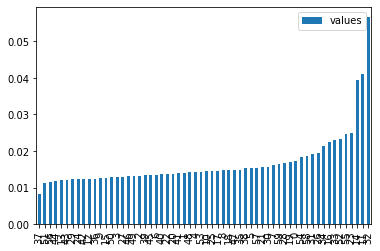

In [263]:
plt.figure(figsize=(100, 200))
feature_imp.sort_values(by='values', ascending=True).plot(kind='bar')
plt.show()

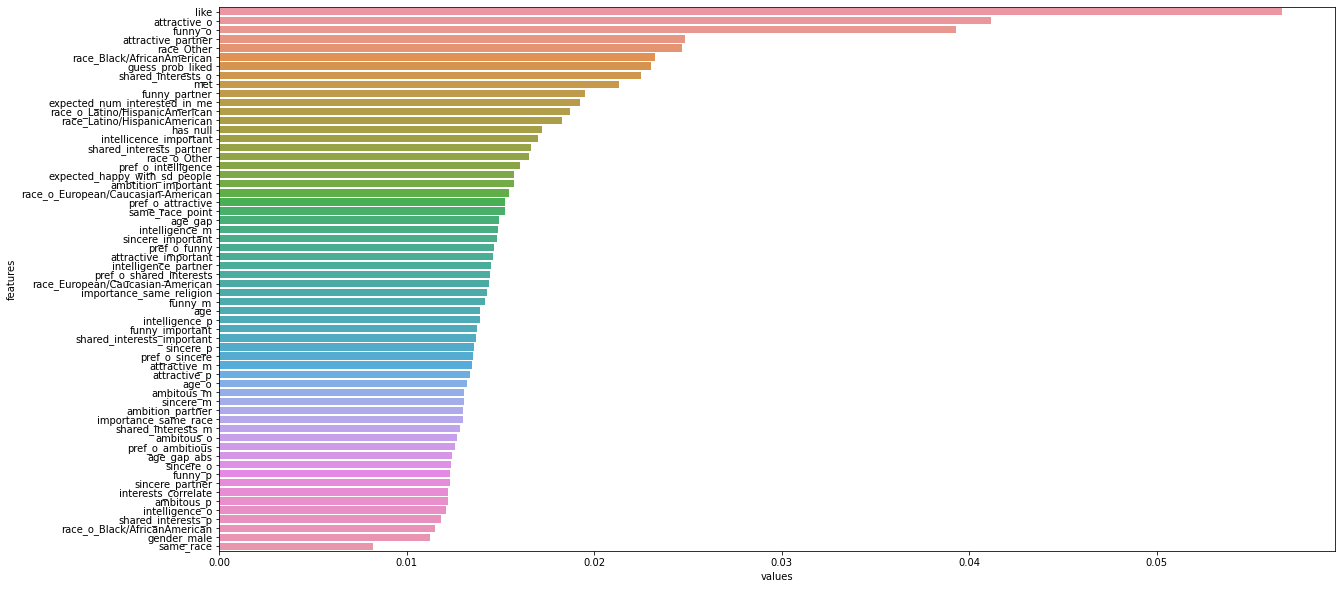

In [264]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))

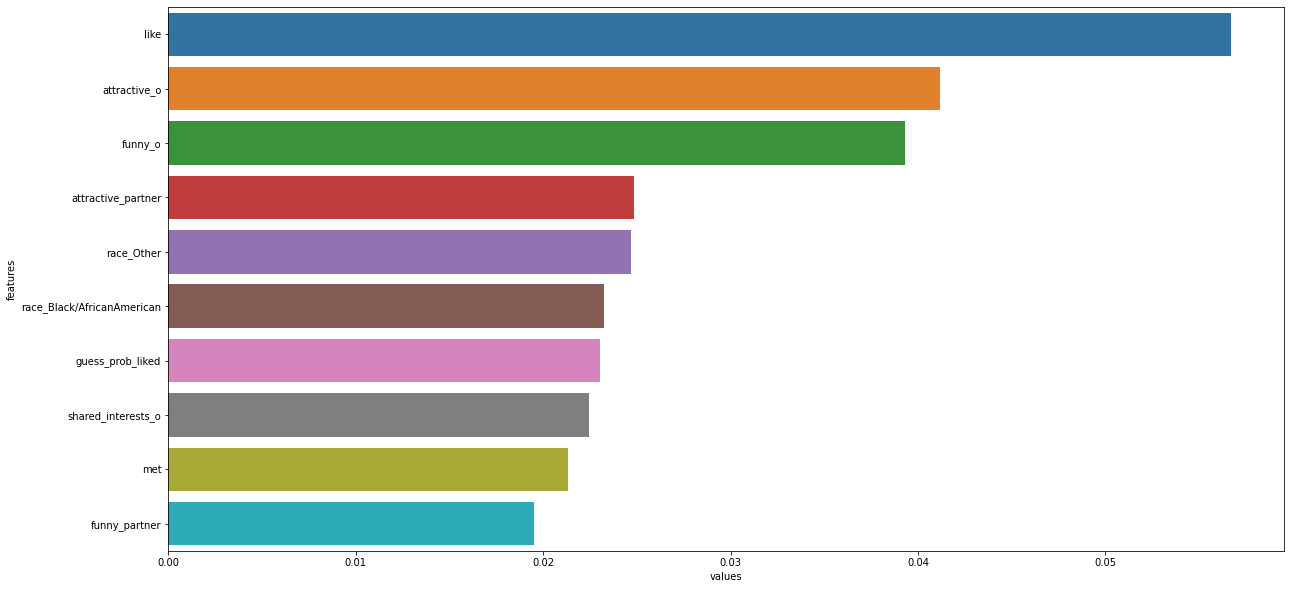

In [265]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False).head(10))
# 상위 10개 출력